# Fitzhugh-Nagumo simplified action-potential model

This example shows how the [Fitzhugh-Nagumo simplified action potential (AP) model](http://pints.readthedocs.io/en/latest/toy/fitzhugh_nagumo_model.html) can be used.

The model is based on a simplification and state-reduction of the original squid axon model by Hodgkind and Huxley.
It has two state variables, a voltage-like variable and a recovery variable.


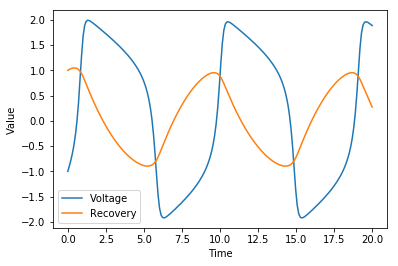

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create a model
model = pints.toy.FitzhughNagumoModel()

# Run a simulation
parameters = [0.1, 0.5, 3]
times = np.linspace(0, 20, 200)
values = model.simulate(parameters, times)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values)
plt.legend(['Voltage', 'Recovery'])
plt.show()

With these parameters, the model creates wide AP waveforms that are more reminiscent of muscle cells than neurons.

We now set up a simple optimisation problem with the model.

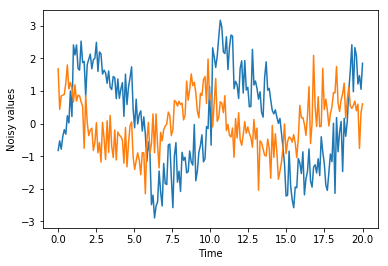

In [2]:
# First add some noise
sigma = 0.5
noisy = values + np.random.normal(0, sigma, values.shape)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Noisy values')
plt.plot(times, noisy)
plt.show()

Next, we set up a problem. Because this model has multiple outputs (2), we use a [MultiOutputProblem](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#multi-output-problem).

In [3]:
problem = pints.MultiOutputProblem(model, times, noisy)
score = pints.SumOfSquaresError(problem)

Finally, we choose a wide set of boundaries and run!

In [4]:
# Select boundaries
boundaries = pints.RectangularBoundaries([0., 0., 0.], [10., 10., 10.])

# Select a starting point
x0 = [1, 1, 1]

# Perform an optimization
found_parameters, found_value = pints.optimise(score, x0, boundaries=boundaries)

print('Score at true solution:')
print(score(parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(parameters[k]))

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      943.7289   0:00.2
1     14     908.4755   0:00.2
2     21     908.4755   0:00.3
3     28     190.9373   0:00.3
20    147    152.225    0:01.7
40    287    100.9938   0:03.9
60    427    99.87823   0:06.2
80    567    99.87628   0:08.5
100   707    99.87628   0:10.8
120   847    99.87628   0:13.0
140   987    99.87628   0:15.2
160   1127   99.87628   0:17.4
180   1267   99.87628   0:19.6
200   1407   99.87628   0:21.9
220   1547   99.87628   0:24.1
240   1687   99.87628   0:26.3
260   1827   99.87628   0:28.6
280   1967   99.87628   0:30.9
300   2107   99.87628   0:33.1
320   2247   99.87628   0:35.4
340   2387   99.87628   0:37.6
360   2527   99.87628   0:39.8
380   2667   99.87628   0:42.1
400   2807   99.87628   0:44.4
420   2947   99.87628   0:46.6
440   3087   99.87628   0:48.9
451   3157   99.87628   0:50

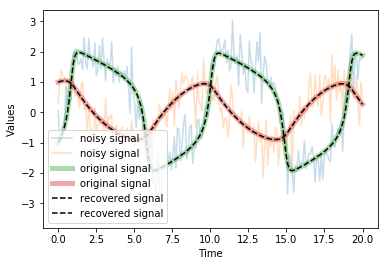

In [5]:
# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy, '-', alpha=0.25, label='noisy signal')
plt.plot(times, values, alpha=0.4, lw=5, label='original signal')
plt.plot(times, problem.evaluate(found_parameters), 'k--', label='recovered signal')
plt.legend()
plt.show()

This shows the parameters are not retrieved entirely correctly, but the traces still strongly overlap.

## Sampling with Monomial-gamma HMC

The Fitzhugh-Nagumo model has sensitivities calculated by the forward sensitivities approach, so we can use samplers that use gradients (although they will be slower per iteration; although perhaps not by ESS per second!), like Monomial-gamma HMC.

In [16]:
import time

problem = pints.MultiOutputProblem(model, times, noisy)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0, 0],
    [10, 10, 10, 20, 20]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(parameters + [sigma, sigma])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
    real_parameters1 * 1.5,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 4, xs, method=pints.MonomialGammaHamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(200)
mcmc.set_log_interval(1)

# Run in parallel
mcmc.set_parallel(True)

for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.05, 0.2, 0.2, 0.1, 0.1])
    sampler.set_leapfrog_steps(10)

# time start
start = time.time()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# end time
end = time.time()
time = end - start

Running...
Using Monomial-Gamma Hamiltonian Monte Carlo
Generating 4 chains.
Running in parallel with 4 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:14.6
1     44     0.333     0.333     0.333     0.333      0:15.5
2     84     0.5       0.5       0.5       0.5        0:16.3
3     124    0.6       0.6       0.6       0.6        0:17.1
4     164    0.667     0.667     0.667     0.667      0:18.0
5     204    0.714     0.714     0.714     0.714      0:18.8
6     244    0.75      0.75      0.75      0.625      0:19.7
7     284    0.667     0.778     0.778     0.556      0:20.5
8     324    0.7       0.8       0.8       0.6        0:21.3
9     364    0.727     0.818     0.818     0.636      0:22.2
10    404    0.75      0.833     0.833     0.667      0:23.0
11    444    0.769     0.846     0.846     0.692      0:23.8
12    484    0.786     0.857     0.857     0.714      0:24.7
13    524    0.8       

132   5284   0.97      0.985     0.97      0.963      2:01.8
133   5324   0.97      0.985     0.97      0.962963   2:02.5
134   5364   0.971     0.985     0.963     0.963      2:03.3
135   5404   0.971     0.985     0.964     0.964      2:04.2
136   5444   0.971     0.986     0.964     0.964      2:05.0
137   5484   0.971223  0.986     0.964     0.964      2:05.8
138   5524   0.971     0.986     0.964     0.964      2:06.6
139   5564   0.972     0.986     0.964539  0.964539   2:07.4
140   5604   0.971831  0.986     0.965     0.965      2:08.1
141   5644   0.972028  0.986014  0.965035  0.965035   2:08.9
142   5684   0.972     0.986     0.965     0.965      2:09.7
143   5724   0.972     0.986     0.966     0.959      2:10.5
144   5764   0.973     0.986     0.966     0.959      2:11.3
145   5804   0.973     0.986     0.966     0.959      2:12.1
146   5844   0.972973  0.986     0.966     0.959      2:12.9
147   5884   0.973     0.987     0.966443  0.96       2:13.7
148   5924   0.973     0

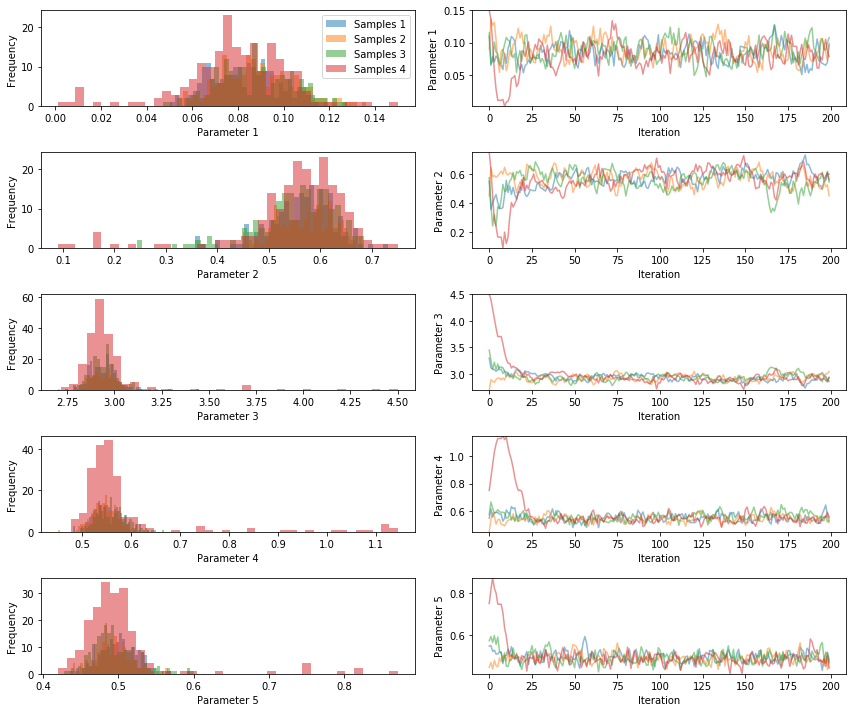

In [18]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Print results.

In [17]:
results = pints.MCMCSummary(chains=chains, time=time, parameter_names=["a", "b", "c", "sigma_V", "sigma_R"])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
a        0.08    0.02    0.05    0.07   0.09   0.10   0.12     1.03    109.80  0.62
b        0.56    0.08    0.37    0.52   0.57   0.61   0.67     1.00    41.35   0.23
c        2.95    0.14    2.82    2.89   2.94   2.98   3.13     1.01    43.38   0.25
sigma_V  0.56    0.07    0.50    0.53   0.55   0.57   0.69     1.03    43.73   0.25
sigma_R  0.50    0.04    0.45    0.48   0.49   0.51   0.57     1.00    84.21   0.48


Plot the few posterior predictive simulations versus data.

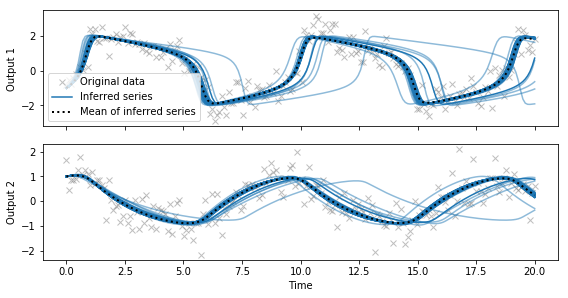

In [19]:
import pints.plot
pints.plot.series(np.vstack(chains), problem)
plt.show()